In [1]:
from collections import defaultdict
import csv
import sys

import matplotlib.pyplot
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff

csv.field_size_limit(sys.maxsize);


In [2]:
IM_ID = '6120_2_2'
POLY_TYPE = '1'  # buildings

# Load grid size
x_max = y_min = None
for _im_id, _x, _y in csv.reader(open('dstl-satellite-imagery-feature-detection/grid_sizes.csv')):
    if _im_id == IM_ID:
        x_max, y_min = float(_x), float(_y)
        break

# Load train poly with shapely
train_polygons = None
for _im_id, _poly_type, _poly in csv.reader(open('dstl-satellite-imagery-feature-detection/train_wkt_v4.csv')):
    if _im_id == IM_ID and _poly_type == POLY_TYPE:
        train_polygons = shapely.wkt.loads(_poly)
        break

# Read image with tiff
im_rgb = tiff.imread('dstl-satellite-imagery-feature-detection/three_band/{}.tif'.format(IM_ID)).transpose([1, 2, 0])
im_size = im_rgb.shape[:2]

In [3]:
def get_scalers():
    h, w = im_size  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

x_scaler, y_scaler = get_scalers()

train_polygons_scaled = shapely.affinity.scale(
    train_polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

In [4]:
def mask_for_polygons(polygons):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask

train_mask = mask_for_polygons(train_polygons_scaled)

In [5]:
def scale_percentile(matrix):
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

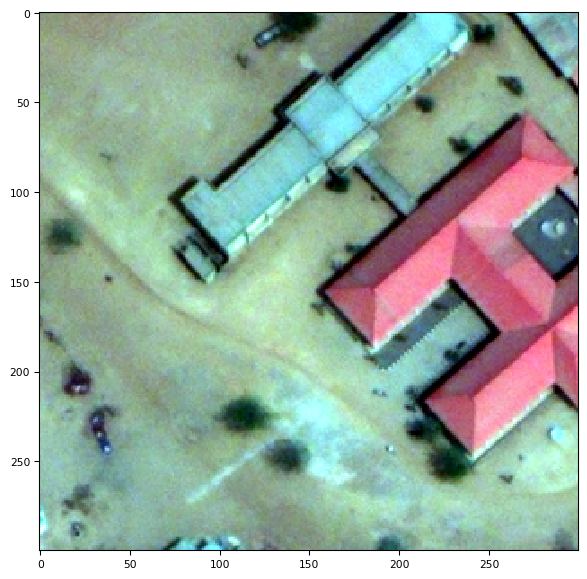

In [6]:
tiff.imshow(255 * scale_percentile(im_rgb[2900:3200,2000:2300]));

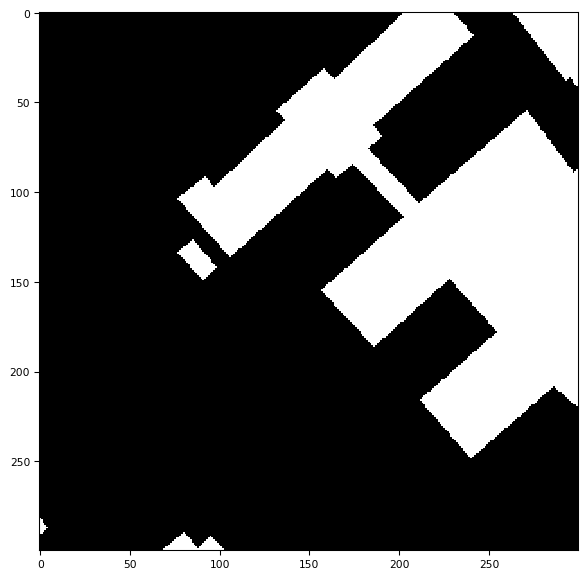

In [7]:
def show_mask(m):
    # hack for nice display
    tiff.imshow(255 * np.stack([m, m, m]));
show_mask(train_mask[2900:3200,2000:2300])

In [8]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import average_precision_score

xs = im_rgb.reshape(-1, 3).astype(np.float32)
ys = train_mask.reshape(-1)
pipeline = make_pipeline(StandardScaler(), SGDClassifier(loss='log'))

print('training...')
# do not care about overfitting here
pipeline.fit(xs, ys)
pred_ys = pipeline.predict_proba(xs)[:, 1]
print('average precision', average_precision_score(ys, pred_ys))
pred_mask = pred_ys.reshape(train_mask.shape)


training...
average precision 0.8324360375197084


In [9]:
def get_unet():
    inputs = Input((8, ISZ, ISZ))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(N_Cls, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

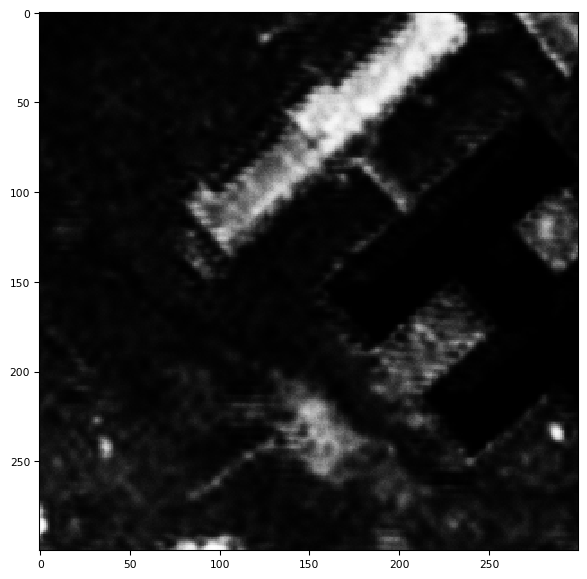

In [10]:
show_mask(pred_mask[2900:3200,2000:2300])

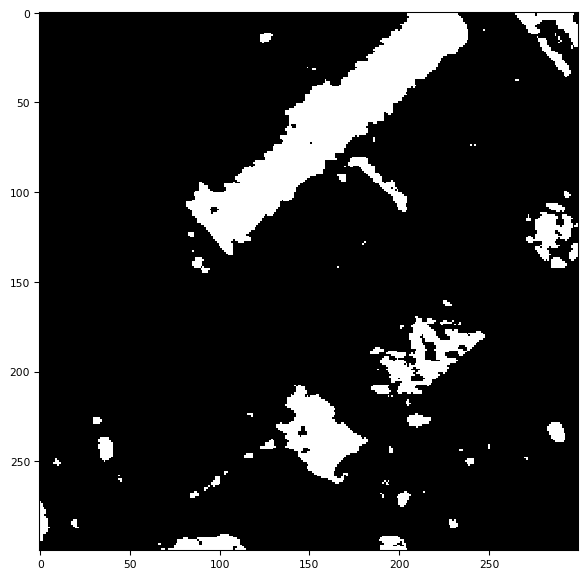

In [11]:
threshold = 0.2
pred_binary_mask = pred_mask >= threshold
show_mask(pred_binary_mask[2900:3200,2000:2300])